# Chain

## Review

ノード、通常のエッジ、条件付きエッジを使用して、シンプルなグラフを構築しました。

## Goals

それでは、4つの[概念](https://python.langchain.com/v0.2/docs/concepts/)を組み合わせたシンプルなチェーンを構築してみましょう：

* グラフの状態として[チャットメッセージ](https://python.langchain.com/v0.2/docs/concepts/#messages)を使用する
* グラフのノード内で[チャットモデル](https://python.langchain.com/v0.2/docs/concepts/#chat-models)を使用する
* チャットモデルに[ツールをバインド](https://python.langchain.com/v0.2/docs/concepts/#tools)する
* グラフのノード内で[ツール呼び出しを実行](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling)する

![Screenshot 2024-08-21 at 9.24.03 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

## Messages

チャットモデルは[`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages)を使用でき、これは会話内のさまざまな役割を捉えます。

LangChainはさまざまなメッセージタイプに対応しており、`HumanMessage`、`AIMessage`、`SystemMessage`、および`ToolMessage`が含まれます。

これらは、ユーザーからのメッセージ、チャットモデルからのメッセージ、チャットモデルに対する動作指示、ツール呼び出しからのメッセージを表します。

それでは、メッセージのリストを作成しましょう。

各メッセージには、以下のような要素を指定できます：

* `content` - メッセージの内容
* `name` - オプションで、メッセージの作成者
* `response_metadata` - オプションで、メタデータの辞書（例：通常`AIMessage`に対してモデルプロバイダによって設定される）

In [ ]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


## Chat Models

[チャットモデル](https://python.langchain.com/v0.2/docs/concepts/#chat-models)は、メッセージのシーケンスを入力として使用でき、前述のメッセージタイプをサポートしています。

選択肢は[たくさんあります](https://python.langchain.com/v0.2/docs/concepts/#chat-models)が、OpenAIを使ってみましょう。

`OPENAI_API_KEY`が設定されているか確認し、設定されていない場合は入力を求められます。

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

チャットモデルを読み込み、メッセージリストを使って呼び出すことができます。

結果は、特定の`response_metadata`を含むAIMessageとして表示されます。

In [ ]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [ ]:
result

AIMessage(content="Orcas, also known as killer whales, can be observed in several locations in the United States, but one of the best places to see them is the Pacific Northwest, particularly around the San Juan Islands in Washington State. \n\n### Key Locations:\n\n1. **San Juan Islands, Washington:**\n   - **Best Time:** The peak season is from May to September, but they can be seen year-round.\n   - **Why It's Great:** The nutrient-rich waters attract a variety of marine life, making it an ideal habitat for orcas. There are both resident and transient orca pods in the area.\n\n2. **Puget Sound, Washington:**\n   - **Best Time:** Summer months, primarily from May to September.\n   - **Why It's Great:** Puget Sound is home to the Southern Resident orcas, which are a unique and endangered population.\n\n3. **Monterey Bay, California:**\n   - **Best Time:** Spring and fall are the best times to see transient orcas.\n   - **Why It's Great:** The nutrient-rich waters of Monterey Bay attra

In [ ]:
result.response_metadata

{'token_usage': {'completion_tokens': 427,
  'prompt_tokens': 67,
  'total_tokens': 494},
 'model_name': 'gpt-4o-2024-05-13',
 'system_fingerprint': 'fp_157b3831f5',
 'finish_reason': 'stop',
 'logprobs': None}

## Tools

ツールは、モデルが外部システムとやり取りしたい場合に便利です。

外部システム（例：API）は、自然言語ではなく、特定の入力スキーマやペイロードを必要とすることが多くあります。

たとえばAPIをツールとしてバインドすると、モデルにその必要な入力スキーマを認識させることができます。

モデルは、ユーザーからの自然言語入力に基づいてツールを呼び出すことを選択します。

そして、ツールのスキーマに準拠した出力を返します。

[多くのLLMプロバイダーがツールの呼び出し](https://python.langchain.com/v0.1/docs/integrations/chat/)をサポートしており、LangChainでの[ツール呼び出しインターフェース](https://blog.langchain.dev/improving-core-tool-interfaces-and-docs-in-langchain/)はシンプルです。

任意のPython `function`を`ChatModel.bind_tools(function)`に渡すだけで利用できます。

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

ツール呼び出しの簡単な例を示しましょう！

multiply関数が私たちのツールです。

In [ ]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

入力を渡すと、たとえば `"What is 2 multiplied by 3"` の場合、ツール呼び出しが返されます。

ツール呼び出しには、関数の入力スキーマに一致する特定の引数と、呼び出す関数の名前が含まれています。

```
{'arguments': '{"a":2,"b":3}', 'name': 'multiply'}
```

In [ ]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_OP4qwtGk4gTIaIySPFHkpbB2', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 62, 'total_tokens': 79}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-534c7657-e889-4a20-b00f-a7e9e1475d5f-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_OP4qwtGk4gTIaIySPFHkpbB2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 62, 'output_tokens': 17, 'total_tokens': 79})

In [ ]:
tool_call.additional_kwargs['tool_calls']

[{'id': 'call_OP4qwtGk4gTIaIySPFHkpbB2',
  'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'},
  'type': 'function'}]

## Using messages as state

これらの基盤が整ったので、グラフの状態に[`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages)を使用できるようになりました。

状態`MessagesState`を、単一のキー`messages`を持つ`TypedDict`として定義しましょう。

`messages`は、単に上で定義したメッセージのリスト（例：`HumanMessage`など）です。

In [ ]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

## Reducers

さて、ちょっとした問題があります！

私たちが話し合ったように、各ノードは状態キー`messages`の新しい値を返します。

しかし、この新しい値は以前の`messages`の値を[上書きしてしまいます](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers)。

グラフが実行されるとき、私たちは`messages`の状態キーにメッセージを**追加**したいのです。

これに対処するために[リデューサ関数](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers)を使用できます。

リデューサを使うことで、状態の更新方法を指定できます。

リデューサ関数が指定されていない場合、キーの更新は*上書きされる*と想定されますが、以前に見たように。

しかし、メッセージを追加するために、事前に構築された`add_messages`リデューサを使用できます。

これにより、既存のメッセージリストに新しいメッセージが追加されることが保証されます。

私たちは単に`messages`キーに`add_messages`リデューサ関数をメタデータとして注釈付けする必要があります。

In [ ]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

メッセージのリストをグラフの状態に持つことは非常に一般的なので、LangGraphには事前に構築された[`MessagesState`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)があります！

`MessagesState`は次のように定義されています：

* 事前構築された単一の`messages`キーを持つ
* これは`AnyMessage`オブジェクトのリストです
* `add_messages`リデューサを使用します

通常、`MessagesState`を使用する方が、上記のようにカスタム`TypedDict`を定義するよりも冗長でなくなります。

In [ ]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built
    pass

もう少し詳しく見ていきましょう。add_messages リデューサーが単独でどのように機能するかを説明します。


In [ ]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', name='Model', id='cd566566-0f42-46a4-b374-fe4d4770ffa7'),
 HumanMessage(content="I'm looking for information on marine biology.", name='Lance', id='9b6c4ddb-9de3-4089-8d22-077f53e7e915'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', name='Model', id='74a549aa-8b8b-48d4-bdf1-12e98404e44e')]

## Our graph

さて、`MessagesState` をグラフと共に使用してみましょう。


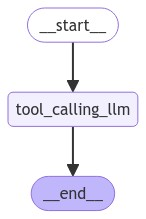

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

If we pass in `Hello!`, the LLM responds without any tool calls.

In [ ]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hi there! How can I assist you today?


LLM は、入力またはタスクがそのツールによって提供される機能を必要とする場合、そのツールを使用することを選択します。


In [ ]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3!
================================== Ai Message ==================================
Tool Calls:
  multiply (call_Er4gChFoSGzU7lsuaGzfSGTQ)
 Call ID: call_Er4gChFoSGzU7lsuaGzfSGTQ
  Args:
    a: 2
    b: 3
